In [1]:
%pylab inline
from pyspark import SparkContext, SparkConf
np.set_printoptions(precision=3, suppress=True)
import numpy as np
import os
import time
start_time = time.time()
from VAT import VAT
from iVAT import iVAT

Populating the interactive namespace from numpy and matplotlib


In [2]:
# INPUTS TO ALGORITHM
set_selector = 25 # This number selects a UCR time series. 76 is a big one.
cl_est = 20        # Initial guess of number of clusters.
sample_ratio = 1.0

# If checking algorithmic performance all additional printing, figure display
# options will be removed.
test_run = True
optimised = True

# Data input - assumes this is done externally - not considered part of complexity.
datapath = 'UCR_TS_Archive_2015/'
datadirlist = os.listdir(datapath)
datadirlist.sort()
datadir = datapath+datadirlist[set_selector]+'/'
datafile = [i for i in os.listdir(datadir) if 'TEST' in i]
f = file(datadir+datafile[0])

# Array of time series data. This is a poor way of doing it because it means the series must be 
# storable in memory before being converted to a RDD.
ts = np.genfromtxt(f, delimiter = ',')
num_series = len(ts)
num_samples = np.ceil(num_series * sample_ratio)
len_series = len(ts[0])
len_series_pow2 = np.power(2,int(np.ceil(np.log2(len_series))))
ts_rows = [i for i in range(num_series)]
for i in range(num_series):
    ts_rows[i] = i, np.append(ts[i,1:], np.zeros(len_series_pow2-len_series))

In [3]:
if not test_run:
    print('There are '+str(num_series)+' series and '+str(len_series)+
          ' samples per series in the \''+datadirlist[set_selector]+'\' dataset.')

    np.where(np.array(os.listdir(datapath)) == 'StarLightCurves')

    plt.plot(ts.T);
    
preprocessing_time = time.time()

In [4]:
# Partitioning component.

# For time series can we assume that the time dimension is reasonable??

# This video covers distributed matrix multiplication
# https://www.youtube.com/watch?v=ap9UOMEMoLw

# Worth noting that correlations are available for MLib but these are only for
# specific types.

# Note that this is always going to be a symmetric output so only need to 
# calculate upper triangle.

# This is actually not the preferred way of distributing data - as we have actually sent this data across all 
# nodes and are just waiting for it to be acted on - in practise this is wasteful.
if optimised:
    ts_distr_rows = sc.parallelize(ts_rows,numSlices=3)
else:
    ts_distr_rows = sc.parallelize(ts_rows)

In [5]:
# z-normalise the time series inputs.
znorm_rows = ts_distr_rows.mapValues(lambda row: row - np.mean(row)/np.std(row))

# Transform to Fourier transform.
ft_rows = znorm_rows.mapValues(lambda row: np.fft.fft(row/np.linalg.norm(row)))
# Possibility for long time series where distribution of initial processing is also necessary.
#ft_rows = znorm_rows.mapValues(lambda row: np.fft.fft(row/np.linalg.norm(row))).coalesce(3) 

In [6]:
rowpart = ft_rows.getNumPartitions()

# Form cartesian product of all elements to form matrix indices
NCC_row = ft_rows.cartesian(ft_rows).map(
    lambda (row, col): ((row[0], col[0]), 1 - np.max(np.fft.ifft(row[1] * np.conj(col[1])))))

def init_array(col_val, num_series = num_series):
    (col, dissimilarity) = col_val
    init_row = np.zeros(num_series)
    init_row[col] = dissimilarity
    return init_row

def build_row(partial_row, next_col_val):
    (col, dissimilarity) = next_col_val
    partial_row[col] = dissimilarity
    return partial_row

NCCrowpart =  NCC_row.getNumPartitions()

# This combines all rows by the row number and produces an array indexed by column number.
if optimised:
    NCC_rowmat = NCC_row.map(lambda ((row, col), dissimilarity): (row, (col, dissimilarity))
                        ).combineByKey(
                            init_array,build_row,(lambda partial_row1, partial_row2: partial_row1 + partial_row2),
                            numPartitions=1)
else:
    NCC_rowmat = NCC_row.map(lambda ((row, col), dissimilarity): (row, (col, dissimilarity))
                        ).combineByKey(
                            init_array,build_row,(lambda partial_row1, partial_row2: partial_row1 + partial_row2))
    
NCCrowmatpart = NCC_rowmat.getNumPartitions()

if not test_run: 
    print NCC_rowmat.take(1)

In [7]:
# This will minimise comms by only sending back the dissimilarity data that is required for the reduced matrix.
# Is sorting required??
# THIS IS THE DISSIMILARITY MATRIX
# sample_ind.sort()

NCC_matrix = NCC_rowmat.collect()

dissim_mat_time = time.time()

NCC_matrix.sort(key = lambda tup: tup[0])

sample_ind = np.array([i[0] for i in NCC_matrix])

NCC_mat_final = np.vstack(tuple(i[1][sample_ind] for i in NCC_matrix))

In [8]:
end_time = time.time()

In [9]:
D_iVAT, D_VAT, I_VAT, C, d = iVAT(NCC_mat_final)

eendtime = time.time()

pre_time = preprocessing_time - start_time
build_dissim_mat = dissim_mat_time - preprocessing_time
produce_matrix = end_time - dissim_mat_time

runtime = end_time - start_time

vattime = eendtime - end_time

print 'Input time series have '+str(rowpart)+' partitions.'
print 'Full cartesian product has '+str(NCCrowpart)+' partitions.'
print 'Combined rows of NCC values have '+str(NCCrowmatpart)+' partitions.'

print('')

print("Pre-processing time = %s seconds ---" % pre_time)
print("Unordered dissimilarity matrix development = %s seconds ---" % build_dissim_mat)
print("Produce matrix =  %s seconds ---" % produce_matrix)
print("Total dissimilarity time =  %s seconds ---" % runtime)
print("Total iVAT time =  %s seconds ---" % vattime)

print('')

print([set_selector,cl_est,sample_ratio,build_dissim_mat,produce_matrix,vattime])

Input time series have 3 partitions.
Full cartesian product has 9 partitions.
Combined rows of NCC values have 1 partitions.

Pre-processing time = 0.492037057877 seconds ---
Unordered dissimilarity matrix development = 21.1021249294 seconds ---
Produce sampled matrix =  0.101102113724 seconds ---
Total dissimilarity time =  21.695264101 seconds ---
Total iVAT time =  15.0066111088 seconds ---

[25, 20, 1.0, 21.1021249294281, 0.10110211372375488, 15.006611108779907]


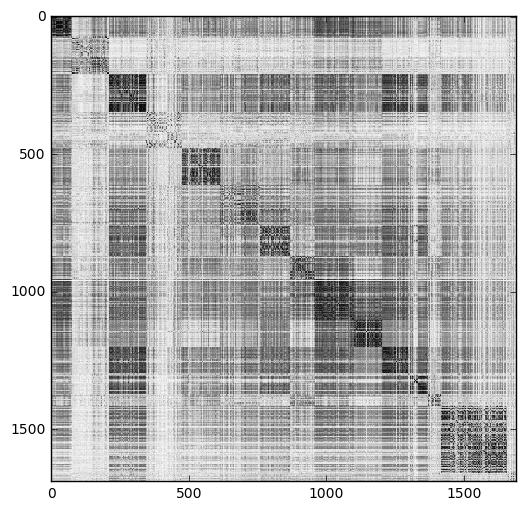

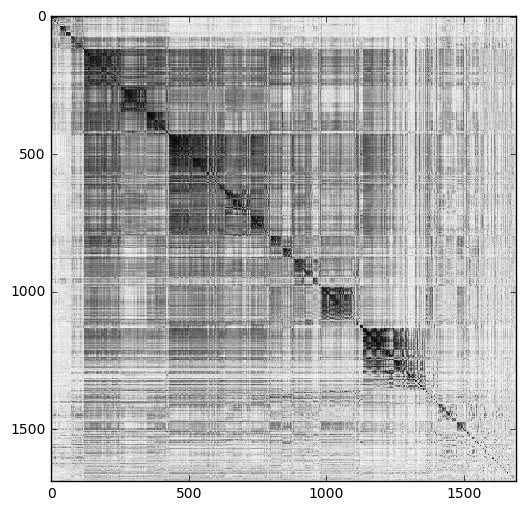

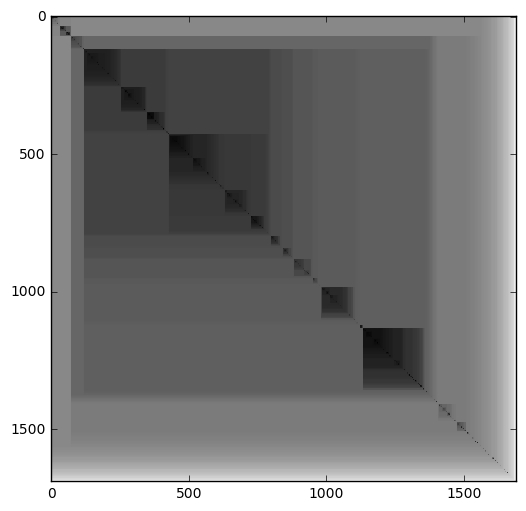

In [10]:
#figure(figsize=(6,6))
#plt.imshow(R_VAT,cmap='Greys_r',interpolation='none');

figure(figsize=(6,6))
plt.imshow(NCC_mat_final,cmap='Greys_r',interpolation='none');

figure(figsize=(6,6))
plt.imshow(D_VAT,cmap='Greys_r',interpolation='none');

figure(figsize=(6,6))
plt.imshow(D_iVAT,cmap='Greys_r',interpolation='none');